In [8]:
import fiona
import shapely
import rasterio
import torch
import pyproj
from rasterio import features
from fiona.transform import transform as f_transform
import numpy as np
from shapely import plotting
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.collections import PatchCollection
from copy import copy
from rasterio import plot as rioplt
from shapely import ops


In [9]:
from itertools import product

def get_tiles(nols, nrows, size, size2=None, step=None, step2=None, col_offset=0, row_offset=0, cover_all=True):
    
    if step is None: step = size
    if size2 is None: size2 = size
    if step2 is None: step2 = step

    max_col_offset = int(np.ceil((nols-size)/step))
    # Remove all offsets such that offset+size > nols and add one offset to
    # reach nols
    col_offsets = list(range(col_offset, col_offset + nols, step))[:max_col_offset+int(cover_all)]
    if cover_all:
        col_offsets[max_col_offset] = col_offset + nols - size

    max_row_offset = int(np.ceil((nrows-size2)/step2))
    # Remove all offsets such that offset+size > nols and add one offset to
    # reach nols
    row_offsets = list(range(row_offset, row_offset + nrows, step2))[:max_row_offset+int(cover_all)]
    if cover_all:
        row_offsets[max_row_offset] = row_offset + nrows - size2

    offsets = product(col_offsets, row_offsets)
    for col_off, row_off in offsets:
        yield rasterio.windows.Window(col_off=col_off, row_off=row_off, width=size, height=size2)

In [10]:
def generate_polygon(bbox):
    """
    Generates a list of coordinates: [[x1,y1],[x2,y2],[x3,y3],[x4,y4],[x1,y1]]
    """
    return [[bbox[0],bbox[1]],
             [bbox[2],bbox[1]],
             [bbox[2],bbox[3]],
             [bbox[0],bbox[3]],
             [bbox[0],bbox[1]]]

In [11]:
def shape_color(name, alpha):
    color = colors.to_rgba(name)
    facecolor = list(color)
    facecolor[-1] = alpha
    facecolor = tuple(facecolor)
    edgecolor = color
    return facecolor, edgecolor

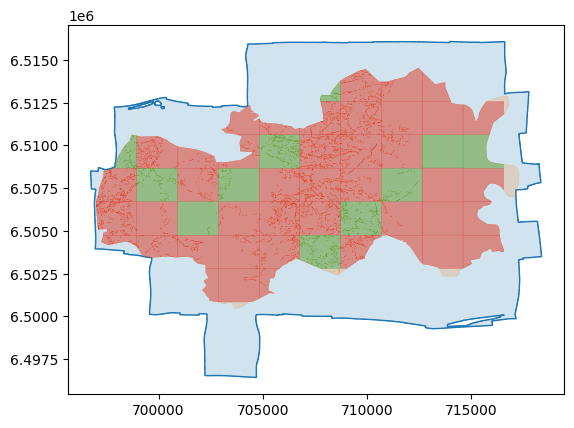

In [33]:
img46 = rasterio.open('/mnt/d/pfournie/Documents/data/alumhi/1946-3.tif', 'r')
label46 = rasterio.open('/mnt/d/pfournie/Documents/data/alumhi/1946-labels.tif', 'r')
shapes46 = fiona.open("/mnt/d/pfournie/Documents/data/alumhi/OCS_1946_210714_VERSION_FINALE_Merge.shp", 'r')

mask46 = img46.dataset_mask()
mask46polys=[]
for shape, value in rasterio.features.shapes(
    mask46, mask=mask46, connectivity=8, transform=img46.transform
):
    poly = shapely.geometry.shape(shape)
    mask46polys.append(poly)

shape_46 = shapely.union_all([shapely.geometry.shape(feature['geometry']) for feature in shapes46])
projection = pyproj.Transformer.from_crs(shapes46.crs, img46.crs, always_xy=True)
shape_46 = ops.transform(projection.transform, shape_46)

minx, miny, maxx, maxy = shape_46.bounds
window_46 = rasterio.windows.from_bounds(minx, miny, maxx, maxy, transform=img46.transform)
window_46 = window_46.round_offsets().round_lengths()

tiles_46 = get_tiles(
    nols=window_46.width,
    nrows=window_46.height,
    size=2000,
    step=2000,
    col_offset=window_46.col_off,
    row_offset=window_46.row_off,
    cover_all=False
)

intersections = []
for tile in tiles_46:
    left, bottom, right, top = rasterio.windows.bounds(tile, transform=img46.transform)
    tile_poly = shapely.Polygon(generate_polygon((left, bottom, right, top)))
    inter = shapely.intersection(tile_poly, shape_46)
    for part in shapely.get_parts(inter):
        if shapely.get_type_id(part)==3 and not part.is_empty and part.area > 5e5:
            intersections.append(part)

fig, ax = plt.subplots()

f1, e1 = shape_color("C0", 0.2)
for poly in mask46polys:
    patch = plotting.patch_from_polygon(poly, facecolor=f1, edgecolor=e1)
    ax.add_patch(patch)

f2, e2 = shape_color("C1", 0.2)
for part in shapely.get_parts(shape_46):
    patch = plotting.patch_from_polygon(
        part, facecolor=f2, edgecolor=e2, linewidth=0.1
    )
    ax.add_patch(patch)

for i, inter_poly in enumerate(intersections):
    f, e = shape_color("C2" if i%5==0 else "C3", 0.4)
    inter_patch = plotting.patch_from_polygon(
        inter_poly, facecolor=f, edgecolor=e, linewidth=0.1
    )
    ax.add_patch(inter_patch)

ax.autoscale_view()

In [45]:
class PolyRaster(torch.utils.data.Dataset):
    
    def __init__(
        self,
        raster_img,
        raster_label,
        polygon,
        crop_size,
        raster_mask_poly=None
    ):
        self.raster_img = raster_img
        self.raster_label = raster_label
        self.polygon = polygon
        self.crop_size = crop_size
        
        #assert crs?
        self.tile = rasterio.windows.from_bounds(
            *polygon.bounds, 
            transform=raster_img.transform
        ).round_offsets().round_lengths()
        
        if raster_mask_poly:
            self.raster_mask_poly = raster_mask_poly
        else:
            mask = raster_img.dataset_mask()
            mask_polys = []
            for shape, value in rasterio.features.shapes(
                mask, mask=mask, connectivity=8, transform=raster_img.transform
            ):
                mask_polys.append(shapely.geometry.shape(shape))
            self.raster_mask_poly = shapely.geometry.MultiPolygon(mask_polys)
        
    def __getitem__(self, idx):
        
        area = 0
        full = False
        while area <= 0.8 or not full:
            cx = self.tile.col_off + np.random.randint(0, self.tile.width - self.crop_size + 1)
            cy = self.tile.row_off + np.random.randint(0, self.tile.height - self.crop_size + 1)
            # raster pixel coords
            crop = rasterio.windows.Window(cx, cy, self.crop_size, self.crop_size)
            left, bottom, right, top = rasterio.windows.bounds(
                crop,
                transform=self.raster_img.transform
            )
            crop_poly = shapely.Polygon(generate_polygon((left, bottom, right, top)))
            
            # checking that the crop intersects the train_zone enough
            intersection = shapely.intersection(crop_poly, self.polygon)
            area = shapely.area(intersection) / shapely.area(crop_poly)
            
            # checking that the crop does not contain pixels out of the initial raster mask
            intersection_mask = shapely.intersection(crop_poly, self.raster_mask_poly)
            full = shapely.area(intersection_mask) / shapely.area(crop_poly) == 1
        
        crop_img = self.raster_img.read(window=crop, out_dtype=np.uint8)
        tf_img = rasterio.windows.transform(crop, transform=self.raster_img.transform)
        
        crop_label = self.raster_label.read(window=crop, out_dtype=np.uint8)
        tf_label = rasterio.windows.transform(crop, transform=self.raster_label.transform)
        
        return crop_img, tf_img, crop_label, tf_label

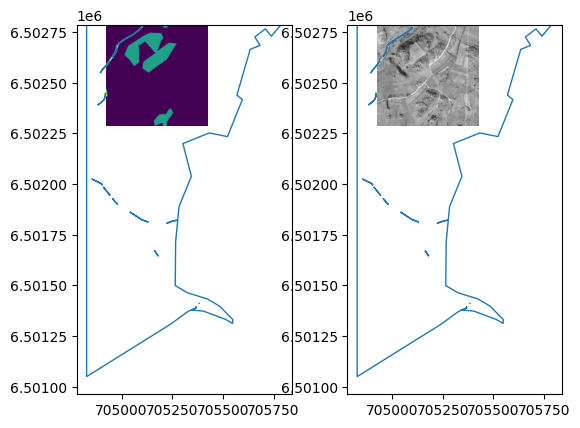

In [70]:
zone = np.random.choice(intersections)
mask46 = shapely.geometry.MultiPolygon(mask46polys)
ds = PolyRaster(
    raster_img=img46,
    raster_label=label46,
    polygon=zone,
    crop_size=512,
    raster_mask_poly=mask46
)

crop_img, tf_img, crop_label, tf_label = ds[0]

fig2, (ax2, ax3) = plt.subplots(1, 2)
f, e = shape_color("C0", 0)
zone_patch = plotting.patch_from_polygon(zone, facecolor=f, edgecolor=e)
ax2.add_patch(copy(zone_patch))
ax3.add_patch(copy(zone_patch))
rioplt.show(crop_label[0,...], ax=ax2, transform=tf_img, cmap='viridis')
rioplt.show(crop_img[0,...], ax=ax3, transform=tf_img, cmap='gray')
ax2.autoscale_view()
ax3.autoscale_view()